In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':15})
#%matplotlib qt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping

import keras
from keras.layers import LSTM, GRU
import tensorflow as tf
from utils import to_1dimension, create_model, plot_series_prediction

#ocultar alertas do módulo keras
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


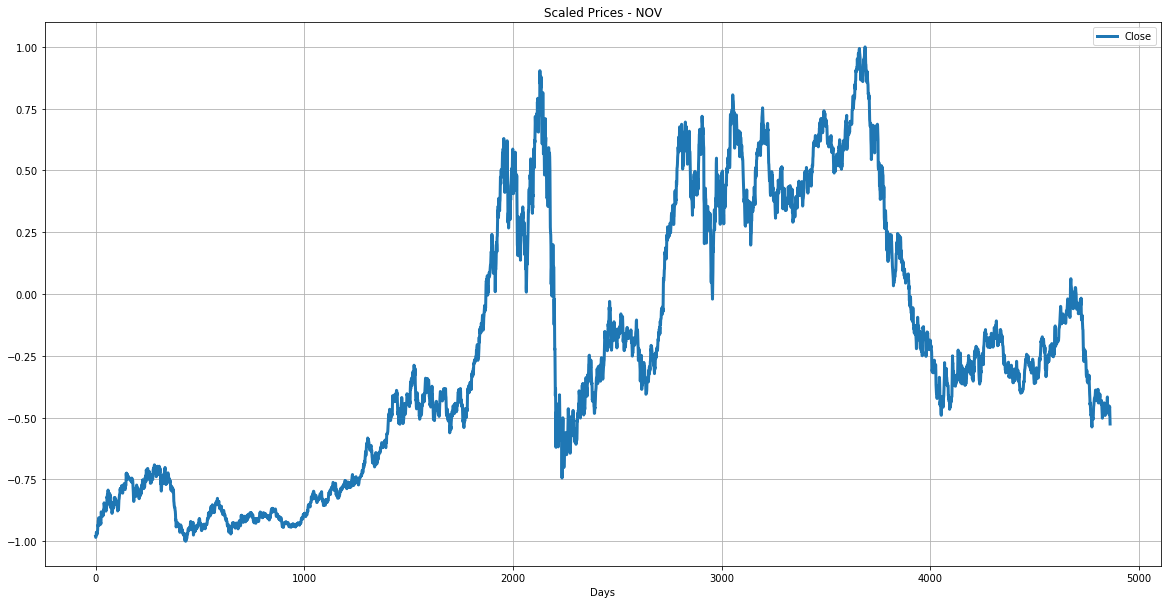

In [7]:
#constantes
#TEST_SIZE = .3
TIME_AHEAD = 1 #dias a prever
BATCH_SIZE = 1
UNITS = 1
TICKER = 'NOV'

df = pd.read_csv('./{}.csv'.format(TICKER))
prices = df.Close

prices = df.Close
scaler = MinMaxScaler(feature_range=(-1,1))
prices = scaler.fit_transform(np.reshape(prices.values, (len(prices), 1)))

#plot
plt.figure(figsize=(20,10))
plt.plot(prices, linewidth=3)
plt.title('Scaled Prices - {}'.format(TICKER))
plt.xlabel('Days')
plt.legend(['Close'])
plt.grid(True)
plt.show()

In [8]:
split = int(len(prices)*.8)
train = prices[:split]
test = prices[split:]

X_train, y_train = to_1dimension(train, TIME_AHEAD)
X_test, y_test = to_1dimension(test, TIME_AHEAD)
print('X_train:{}, y_train:{}'.format(X_train.shape, y_train.shape))
print('X_test:{}, y_test:{}'.format(X_test.shape, y_test.shape))

X_train:(3887, 1, 1), y_train:(3887,)
X_test:(971, 1, 1), y_test:(971,)


In [9]:
#LSTM
model = create_model(model_name='LSTM', units=UNITS, time_ahead=TIME_AHEAD)
'''Para otimização, usamos o algoritmo ADAM.
    Em séries temporais, os métodos de otimização adaptativa
    tendem a obter melhores resultados do que os métodos
    tradicionais de descida de gradiente estocástica.'''
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
model.compile(optimizer='nadam', loss='mse', metrics=['mse','mae'])
model.fit(X_train,
          y_train,
          epochs=100,
          batch_size=BATCH_SIZE,
          callbacks=[early_stop],
          verbose=1)

Epoch 1/100
3887/3887 [==============================] - 7s 2ms/step - loss: 0.0494 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1139
Epoch 2/100
3887/3887 [==============================] - 7s 2ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0303
Epoch 3/100
3887/3887 [==============================] - 7s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0258
Epoch 4/100
3887/3887 [==============================] - 7s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0242
Epoch 5/100
3887/3887 [==============================] - 7s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0233
Epoch 6/100
3887/3887 [==============================] - 7s 2ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0229
Epoch 7/100
3887/3887 [==============================] - 7s 2ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0224

ValueError: x and y can be no greater than 2-D, but have shapes (3886,) and (3886, 1, 1)

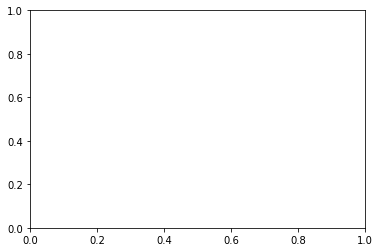

In [20]:
#recuperamos os valores originais em y_test e prices
y_test_origin = scaler.inverse_transform([y_test])
prices_origin = scaler.inverse_transform(prices)

pred_train = model.predict(X_train)

#pred_test = scaler.inverse_transform(pred_test)
plt.plot(X_train, color='red')
plt.plot(pred_train)
plt.show()
print('R2 score on the test set: {:0.3f}'.format(r2_score(y_train, pred_train)))


#pred_train = model.predict(X_train)
#pred_train = scaler.inverse_transform(pred_train)
#plot_series_prediction(prices_origin, pred_train, pred_test, time_ahead=TIME_AHEAD,
                        #title='Predictions', xlabel='Days', ylabel='Prices of AMZN Stock',
                        #legend=['Opening prices', 'Training set', 'Test prediction'])

971 973


ValueError: x and y must have same first dimension, but have shapes (971,) and (973, 1)

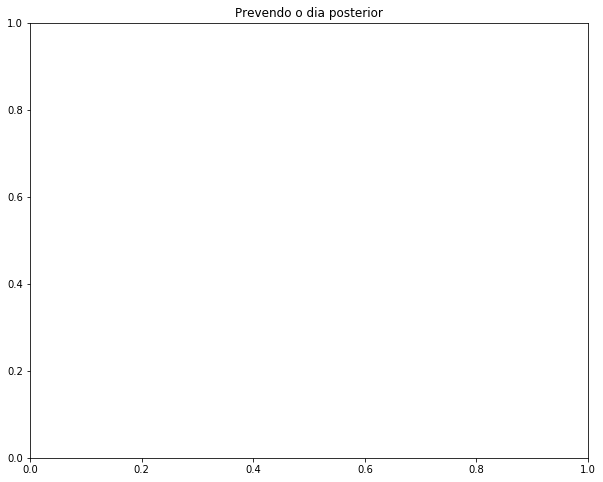

In [19]:
plt.figure(figsize=(10,8))
plt.title('Prevendo o dia posterior')
print(len(pred_test), len(prices[split:]))
plt.plot(np.arange(len(pred_test)),prices[split:], label = 'observado')
plt.plot(pred_test, label = 'predito')
plt.legend()
plt.show()

In [8]:
#train, test = train_test_split(prices, test_size=TEST_SIZE, shuffle=False)
TIME_AHEAD = 22 #dias a prever
train = prices[:1000]
test = prices[1000:]
print('dimensions of train:', train.shape)
print('dimensions of test:', test.shape)

X_train, y_train = to_1dimension(train, TIME_AHEAD)
X_test, y_test = to_1dimension(test, TIME_AHEAD)

#LSTM
model = create_model(model_name='LSTM', units=UNITS, time_ahead=TIME_AHEAD)
'''Para otimização, usamos o algoritmo ADAM.
    Em séries temporais, os métodos de otimização adaptativa
    tendem a obter melhores resultados do que os métodos
    tradicionais de descida de gradiente estocástica.'''
model.compile(optimizer='nadam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=BATCH_SIZE, verbose=1)

#recuperamos os valores originais em y_test e prices
y_test_origin = scaler.inverse_transform([y_test])
prices_origin = scaler.inverse_transform(prices)

pred_test = model.predict(X_test)
pred_test = scaler.inverse_transform(pred_test)
error = mean_squared_error(y_test_origin[0], pred_test[:,0])
print('MSE: %.2f' % error)

#pred_train = model.predict(X_train)
#pred_train = scaler.inverse_transform(pred_train)
#plot_series_prediction(prices_origin, pred_train, pred_test, time_ahead=TIME_AHEAD,
                        #title='Predictions', xlabel='Days', ylabel='Prices of AMZN Stock',
                        #legend=['Opening prices', 'Training set', 'Test prediction'])

dimensions of train: (1000, 1)
dimensions of test: (259, 1)
Epoch 1/10
977/977 [==============================] - 4s 4ms/step - loss: 0.0017
Epoch 2/10
977/977 [==============================] - 3s 3ms/step - loss: 2.4925e-04
Epoch 3/10
977/977 [==============================] - 3s 3ms/step - loss: 2.3203e-04
Epoch 4/10
977/977 [==============================] - 3s 3ms/step - loss: 2.1792e-04
Epoch 5/10
977/977 [==============================] - 3s 3ms/step - loss: 1.9728e-04
Epoch 6/10
977/977 [==============================] - 3s 3ms/step - loss: 1.8001e-04
Epoch 7/10
977/977 [==============================] - 3s 3ms/step - loss: 1.7373e-04
Epoch 8/10
977/977 [==============================] - 3s 3ms/step - loss: 1.6011e-04
Epoch 9/10
977/977 [==============================] - 3s 3ms/step - loss: 1.5254e-04
Epoch 10/10
977/977 [==============================] - 3s 3ms/step - loss: 1.4975e-04
MSE: 4296.99


In [20]:
pred_train = model.predict(X_train)
pred_train = scaler.inverse_transform(pred_train)
X = np.append(pred_train, pred_test)

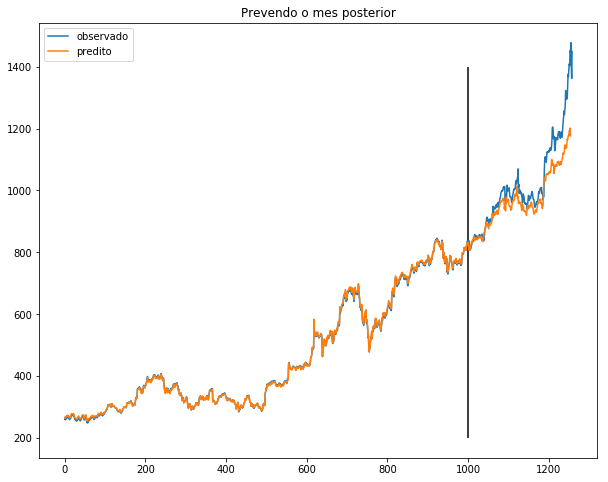

In [27]:
plt.figure(figsize=(10,8))
plt.title('Prevendo o mes posterior')
plt.plot(np.arange(0,1259),df['open'], label = 'observado')
plt.plot(X, label = 'predito')
plt.vlines(1000, 200, 1400)
plt.legend()
plt.show()

In [18]:
df

,date,open,high,low,close
0,2013-02-08,261.40,265.250,260.5550,261.950
1,2013-02-11,263.20,263.250,256.6000,257.210
2,2013-02-12,259.19,260.160,257.0000,258.700
3,2013-02-13,261.53,269.960,260.3000,269.470
4,2013-02-14,267.37,270.650,265.4000,269.240
5,2013-02-15,267.63,268.920,263.1100,265.090
6,2013-02-19,265.91,270.110,264.5000,269.750
7,2013-02-20,270.20,274.300,266.3710,266.410
8,2013-02-21,265.12,269.480,263.2500,265.940
9,2013-02-22,266.62,267.110,261.6100,265.420
